# Thinking1：逻辑回归的假设条件是怎样的？

1. 数据的标签需要服从伯努利分布，也就是0/1非此即彼的分布。
2. 正类的概率有sigmoid函数进行计算得出的。
3. 数据特征分布最好是正态分布的，尽量避免长尾的数据分布。

# Thinking2：逻辑回归的损失函数是怎样的？

1. 预测函数为：$h_{\theta}(x)=g(\theta^Tx)=sigmod(\theta^Tx)$
2. 综合公式：$P(y|x;\theta)=(h_{\theta}(x))^y(1-h_{\theta}(x))^{1-y}$
3. $l(\theta)=logL(\theta)=\sum^m_{i=1}(y^{(i)}logh_{\theta}(x^{(i)})+(1-y^{(i)})log(1-h_{\theta}(x^{(i)})))$
4. 损失函数：$J(\theta)=-\frac{1}{m}l(\theta)$

# Thinking3：逻辑回归如何进行分类？

1. 每一个特征会有一个权重，所有的特征值与权重加权求和之后，通过sigmoid函数可以映射到0-1范围内的数值
2. 可以假设通过sigmoid之后大于0.5的属于1的标签，小于0.5的属于0的标签。

# Thinking4：为什么在训练中需要将高度相关的特征去掉？

1. 高度相关的特征容易共线性，把权重平分了，减弱了模型参数的解释能力。
2. 既然用一个特征的效果等于用多个相关性特征的效果，多用几个就相当于浪费的存储和计算的资源。
3. 从信息的角度看，高度相关的特征并不能提供额外能利用的信息，也就是多个跟一个特征提供的信息量相同。

# Action1: 基于评分卡的风控模型开发

1. https://www.kaggle.com/c/GiveMeSomeCredit/data
2. 数据集GiveMeSomeCredit，15万样本数据
3. 使用WOE进行特征变换，IV进行特征筛选，LR构建风控模型，并对模型评分规则进行可解释性说明 
    * 基本属性：包括了借款人当时的年龄
    * 偿债能力：包括了借款人的月收入、负债比率
    * 信用往来：两年内35-59天逾期次数、两年内60-89天逾期次数、两年内90天或高于90天逾期的次数
    * 财产状况：包括了开放式信贷和贷款数量、不动产贷款或额度数量。
    * 其他因素：包括了借款人的家属数量

## 数据探索

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
raw = pd.read_csv('./cs-training.csv')
raw.drop('Unnamed: 0', axis=1, inplace=True)
raw.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [4]:
# 缺失值
temp = raw.isnull().sum()
df_null = temp[temp != 0]
null_col = df_null.index
df_null

MonthlyIncome         29731
NumberOfDependents     3924
dtype: int64

In [5]:
# 重复值
raw.duplicated().sum()

609

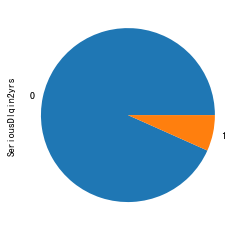

In [6]:
# 标签分布
raw['SeriousDlqin2yrs'].value_counts().plot(kind='pie')
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler

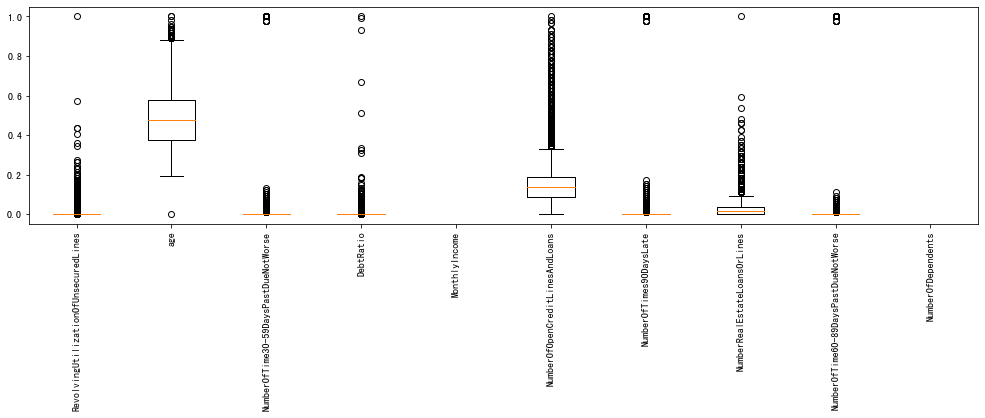

In [8]:
# 特征分布
feature_col = [x for x in raw.columns if x != 'SeriousDlqin2yrs']
box = raw[feature_col]
box_data = MinMaxScaler().fit_transform(box)
plt.figure(figsize=(17,4))
plt.boxplot(box_data, labels=box.columns)
plt.xticks(rotation=90)
plt.show()

## 数据清洗

In [9]:
# 缺失值填充
df_data = raw.fillna({'MonthlyIncome': raw['MonthlyIncome'].mean(), 'NumberOfDependents': 0.0})

# 重复值删除
df_data.drop_duplicates(inplace=True, ignore_index=True)

## 变量 WOE 值计算

In [10]:
def get_woe_and_iv(df, labels, col, strategy='distance', bins=None):

    # 数据分桶
    df = df[[col]+[labels]]

    if strategy == 'distance':
        df['bins'] = pd.cut(df[col], bins=bins)
    elif strategy == 'frequency':
        df['bins'] = pd.qcut(df[col], q=bins, duplicates='drop')
    
    woe_detail = df['bins'].value_counts().reset_index().rename(columns={'bins': 'total', 'index': 'bins'})
    
    # 计算每个属性 good(not event) 和 bad(event) 的个数
    temp = df.groupby('bins')[labels].value_counts().unstack().reset_index().rename(columns={0: 'good_total', 1: 'bad_total'})
    woe_detail = pd.merge(woe_detail, temp, on='bins', how='left')
    woe_detail.fillna(value={'good_total': 0, 'bad_total': 0}, inplace=True)
    
    # 计算每个属性 good 和 bad 的占比
    woe_detail['good_ratio'] = woe_detail['good_total'] / woe_detail['good_total'].sum()
    woe_detail['bad_ratio'] = woe_detail['bad_total'] / woe_detail['bad_total'].sum()
    
    # 计算 woe 值
    woe_detail['woe'] = np.log1p(woe_detail['bad_ratio'] / woe_detail['good_ratio'])
    woe_detail.sort_values('woe', inplace=True, ascending=False)
    
    # 计算 Odds 值
    c = woe_detail['bad_total'].sum() / woe_detail['good_total'].sum()
    woe_detail['odds'] = np.log1p(c) + woe_detail['woe']
    
    # 单调性检验
    woe_detail['Monotonicity'] = woe_detail['odds'].diff().apply(lambda x: True if x <= 0.0 else False)
    
    # 计算 IV 值
    iv_score = ((woe_detail['bad_ratio'] - woe_detail['good_ratio']) * woe_detail['woe']).sum()
    
    return woe_detail, iv_score, df['bins']

In [11]:
data_dict = {
    
    'RevolvingUtilizationOfUnsecuredLines': {
        'strategy': 'frequency', 
        'bins': [0, 0.2, 0.4, 0.6, 0.8, 1]
    },
    
     'age': {
        'strategy': 'distance', 
        'bins': [-float('inf'), 25, 40, 50, 60, 70, float('inf')]

    },
    
    'NumberOfTime30-59DaysPastDueNotWorse': {
        'strategy': 'distance', 
        'bins': [-float('inf'), 1, 2, 3, 4, 5, 6, 7, 8, 9, float('inf')]
    },
    
    'DebtRatio': {
        'strategy': 'frequency', 
        'bins': [0, 0.2, 0.4, 0.6, 0.8, 1]
    },

    'MonthlyIncome': {
        'strategy': 'frequency', 
        'bins': [0, 0.2, 0.4, 0.6, 0.8, 1]
    },

    'NumberOfOpenCreditLinesAndLoans': {
        'strategy': 'frequency', 
        'bins': [0, 0.2, 0.4, 0.6, 0.8, 1]
    },
    
    'NumberOfTimes90DaysLate': {
        'strategy': 'distance', 
        'bins': [-float('inf'), 1, 2, 3, 4, 5, 6, 7, 8, 9, float('inf')]
    },
    
    'NumberRealEstateLoansOrLines': {
        'strategy': 'frequency', 
        'bins': [0, 0.2, 0.4, 0.6, 0.8, 1]
    },
    
    'NumberOfTime60-89DaysPastDueNotWorse': {
        'strategy': 'distance', 
        'bins': [-float('inf'), 1, 2, 3, 4, 5, 6, 7, 8, 9, float('inf')]
    },
    
    'NumberOfDependents': {
        'strategy': 'distance', 
        'bins': [-float('inf'), 2, 4, 6, 8, 10, float('inf')]
    },
}

df_bin_record = {}
df_bin_record_detail = {}
df_iv = {'columns':[], 'iv': []}
for (key, value) in data_dict.items():
    df_woe, iv, bins_detail = get_woe_and_iv(df_data, 'SeriousDlqin2yrs' ,key , strategy=value['strategy'], bins=value['bins'])
    df_iv['columns'].append(key)
    df_iv['iv'].append(iv)
    df_bin_record[key] = df_woe
    df_bin_record_detail[key] = bins_detail

df_iv = pd.DataFrame(df_iv).sort_values('iv', ascending=False)
df_iv

,columns,iv
0,RevolvingUtilizationOfUnsecuredLines,0.529013
6,NumberOfTimes90DaysLate,0.375380
2,NumberOfTime30-59DaysPastDueNotWorse,0.340914
8,NumberOfTime60-89DaysPastDueNotWorse,0.203844
1,age,0.105887
4,MonthlyIncome,0.034784
3,DebtRatio,0.032071
5,NumberOfOpenCreditLinesAndLoans,0.026478
9,NumberOfDependents,0.007775
7,NumberRealEstateLoansOrLines,0.006124


In [12]:
df_bin_record['RevolvingUtilizationOfUnsecuredLines']

,bins,total,good_total,bad_total,good_ratio,bad_ratio,woe,odds,Monotonicity
0,"(0.694, 50708.0]",29847,23884,5963,0.171545,0.596062,1.498433,1.567822,False
3,"(0.271, 0.694]",29846,27761,2085,0.199391,0.208417,0.715528,0.784917,True
1,"(0.0835, 0.271]",29847,28970,877,0.208074,0.087665,0.351583,0.420971,True
2,"(-0.001, 0.0195]",29847,29263,584,0.210179,0.058377,0.245099,0.314487,True
4,"(0.0195, 0.0835]",29846,29351,495,0.210811,0.049480,0.210839,0.280228,True


## 筛选变量并生成评分卡

In [13]:
# 筛选 iv 值大于 0.1 的变量
iv_col = [x['columns'] for _, x in df_iv.iterrows() if x['iv'] > 0.1]
iv_col

['RevolvingUtilizationOfUnsecuredLines',
 'NumberOfTimes90DaysLate',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'age']

In [14]:
# 生成评分卡
score_card = pd.DataFrame(data=None)
for column in iv_col:
    temp = df_bin_record[column][['bins', 'woe']]
    temp['column'] = column
    score_card = pd.concat([score_card, temp], axis=0, ignore_index=True)

In [15]:
score_card

,bins,woe,column
0,"(0.694, 50708.0]",1.498433,RevolvingUtilizationOfUnsecuredLines
1,"(0.271, 0.694]",0.715528,RevolvingUtilizationOfUnsecuredLines
2,"(0.0835, 0.271]",0.351583,RevolvingUtilizationOfUnsecuredLines
3,"(-0.001, 0.0195]",0.245099,RevolvingUtilizationOfUnsecuredLines
4,"(0.0195, 0.0835]",0.210839,RevolvingUtilizationOfUnsecuredLines
5,"(6.0, 7.0]",4.137307,NumberOfTimes90DaysLate
6,"(8.0, 9.0]",3.688092,NumberOfTimes90DaysLate
7,"(7.0, 8.0]",3.577762,NumberOfTimes90DaysLate
8,"(3.0, 4.0]",3.376549,NumberOfTimes90DaysLate
9,"(4.0, 5.0]",3.221488,NumberOfTimes90DaysLate


## woe 编码

In [16]:
from collections import defaultdict

In [17]:
col_bins_woe_dict = defaultdict(dict)
for col, group in score_card.groupby('column'):
    for i, j in group.iterrows():
        col_bins_woe_dict[col][j['bins']] = j['woe']
        
train_data = df_data[iv_col]

for col in iv_col:
    train_data[col] = df_bin_record_detail[col].apply(lambda x: col_bins_woe_dict[col][x])
    
train_data.head()

,RevolvingUtilizationOfUnsecuredLines,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,age
0,1.498433,0.60922,1.795217,0.645913,0.812837
1,1.498433,0.60922,0.573038,0.645913,0.954127
2,0.715528,0.60922,0.573038,0.645913,0.954127
3,0.351583,0.60922,0.573038,0.645913,0.954127
4,1.498433,0.60922,0.573038,0.645913,0.812837


## 模型训练

### 数据集拆分

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x_train, x_val, y_train, y_val = train_test_split(train_data, df_data['SeriousDlqin2yrs'], test_size=0.2, random_state=529)

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_val', x_val.shape)
print('y_val', y_val.shape)

x_train (119386, 5)
y_train (119386,)
x_val (29847, 5)
y_val (29847,)


### 数据平衡

In [20]:
from imblearn.over_sampling import SMOTE

In [21]:
over_samples = SMOTE(random_state=None, k_neighbors=5)
over_samples_X, over_samples_y = over_samples.fit_sample(x_train.values, y_train.values.ravel())

print('over_samples_X', over_samples_X.shape)
print('over_samples_y', over_samples_y.shape)

over_samples_X (222764, 5)
over_samples_y (222764,)


In [22]:
# 正例样本和整体样本比例
over_samples_y.sum() / len(over_samples_y)

0.5

### LR训练

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

In [24]:
def print_report(y_true, y_pre, y_score):
    print('f1:{:.2f}%'.format(f1_score(y_pre, y_true)*100))
    print('acc:{:.2f}%'.format(accuracy_score(y_pre, y_true)*100))
    print('rec:{:.2f}%'.format(recall_score(y_pre, y_true)*100))
    print('pre:{:.2f}%'.format(precision_score(y_pre, y_true)*100))
    print('auc:{:.2f}%'.format(roc_auc_score(y_val, y_score[:,1])*100))

In [25]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
predict = lr.predict(x_val)
predict_proba = lr.predict_proba(x_val)

print('不做样本平衡')
print_report(y_val, predict, predict_proba)

不做样本平衡
f1:21.91%
acc:93.74%
rec:66.84%
pre:13.10%
auc:82.34%


In [26]:
lr_weight = LogisticRegression(class_weight='balanced')
lr_weight.fit(x_train, y_train)
predict = lr_weight.predict(x_val)
predict_proba = lr_weight.predict_proba(x_val)

print('calss weight 平衡')
print_report(y_val, predict, predict_proba)

calss weight 平衡
f1:32.01%
acc:80.12%
rec:20.76%
pre:69.85%
auc:82.45%


In [27]:
lr_over = LogisticRegression()
lr_over.fit(over_samples_X, over_samples_y)
predict = lr_over.predict(x_val)
predict_proba = lr_over.predict_proba(x_val)

print('SMOTE 样本平衡')
print_report(y_val, predict, predict_proba)

SMOTE 样本平衡
f1:32.01%
acc:80.12%
rec:20.76%
pre:69.85%
auc:82.44%


**针对于风险评估问题，综合来说不做样本平衡的模型较好**
1. 召回比做样本平衡的模型好，对潜在风险的识别能力比较好
2. auc值几乎一样
3. 对于精确度和召回的取舍看实际情况对于要识别出还是准去的识别这两个需求哪个比较看重

## 评分卡模型生成
$score = A - B * ln(Odds)=A-B * \theta ^Tx$

In [77]:
A = 650
B = 72
df_data['score'] = A - B * (np.dot(train_data.values, lr.coef_.T))
df_data[['SeriousDlqin2yrs', 'score']]

,SeriousDlqin2yrs,score
0,1,262.634
1,0,329.995
2,0,411.219
3,0,448.978
4,0,340.851
...,...,...
149228,0,515.25
149229,0,422.076
149230,0,472.314
149231,0,460.026


## 评分卡模型评估
1. 随机5个不违约的客户
2. 随机5个违约的客户
3. 整体评估

In [101]:
import random

In [102]:
bad_random = random.sample(df_data[df_data['SeriousDlqin2yrs']==1].index.tolist(),5)
good_random = random.sample(df_data[df_data['SeriousDlqin2yrs']==0].index.tolist(),5)

In [103]:
df_data.iloc[bad_random+good_random][['SeriousDlqin2yrs', 'score']]

,SeriousDlqin2yrs,score
135151,1,353.331
149171,1,310.399
42765,1,486.916
140692,1,411.219
3024,1,240.031
51593,0,474.436
126902,0,515.25
59032,0,460.026
4403,0,486.916
15862,0,381.665


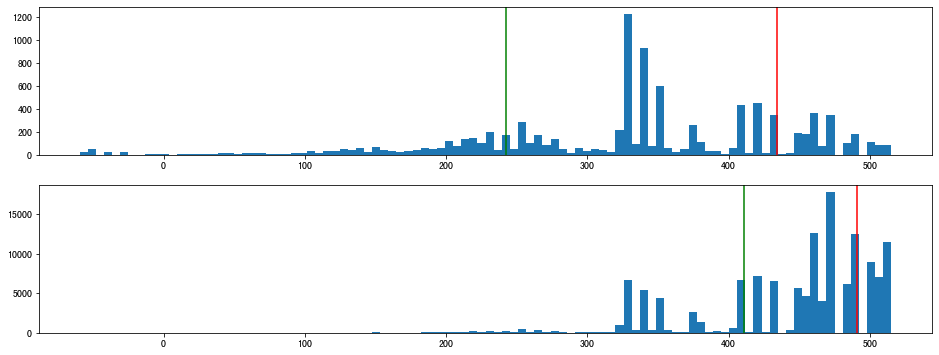

In [139]:
df_bad = df_data[df_data['SeriousDlqin2yrs']==1][['SeriousDlqin2yrs', 'score']]
df_good = df_data[df_data['SeriousDlqin2yrs']==0][['SeriousDlqin2yrs', 'score']]

fig, ax = plt.subplots(2, 1, figsize=(16, 6))

for idx, df in enumerate([df_bad, df_good]):
    ax[idx].hist(df['score'], bins=100)
    ax[idx].axvline(df['score'].quantile(0.2), color='g')
    ax[idx].axvline(df['score'].quantile(0.8), color='r')
plt.show()

1. 绿线往右 -> 前20%数据
2. 红色往左 -> 后20%数据

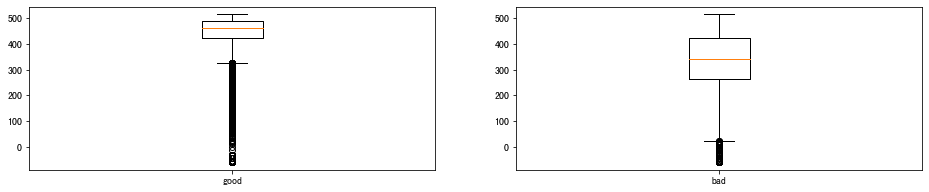

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(16, 3))
ax[0].boxplot(df_good['score'])
ax[0].set_xticklabels(['good'])
ax[1].boxplot(df_bad['score'])
ax[1].set_xticklabels(['bad'])
plt.show()